# MSDS 7331 - Case Study 2 - Diabetes Prediction
Daniel Crouthamel  
Sophia Wu  
Fabio Savorgnan  
Bo Yun  

# Introduction

In this study, we will build a classifier using logistic regression to predict hospital readmittance. There is missing data that must be imputed. We'll discuss variable importances for the target variable,which is hospital readmittance.
There are total six sections in this case analysis:

1. Business Understanding

You should always state the objective at the beginning of every case (a guideline you should follow in real life as well) and provide some initial "Business Understanding" statements (i.e., what is trying to be solved for and why might it be important)


2. Data Evaluation / Engineering

Summarize the data being used in the case using appropriate mediums (charts, graphs, tables); address questions such as: Are there missing values? Which variables are needed (which ones are not)? What assumptions or conclusions are you drawing that need to be relayed to your audience?


3. Modeling Preparations
Fabio

Which methods are you proposing to utilize to solve the problem?  Why is this method appropriate given the business objective? How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?

using AUC to decide between l1 and l2, grid search

4. Model Building & Evaluation
Dan:

"In this case, your primary task is to build a logistic regression to predict hospital readmittances and will involve the following steps:

- Explain how you handled missing values
- Specify your sampling methodology
- Setup your model(s) - highlighting any important parameters
- Analyze your model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)"

Bo:
Threshold and affect on recall
How SMOTE can affect the threshold

5. Model Interpretability & Explainability
Bo: Practical section, 95% recall
Dan; Feature importance

"Using at least one of your models above (if multiple were trained):

- Which variable(s) was (were) ""most important"" and why?  How did you come to the conclusion and how should your audience interpret this?"


6. Case Conclusions

Sophia:

After all of your technical analysis and modeling; what are you proposing to your audience and why?  How should they view your results and what should they consider when moving forward?  Are there other approaches you'd recommend exploring?  This is where you "bring it all home" in language they understand.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import RobustScaler
# Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Bussiness Understanding

According to the Healthcare Cost and Utilization Project (H-CUP) conducted by the Agency for Healthcare Research and Quality (AHRQ), the national benchmark 30-day all cause readmission rate for patients with diabetes is 19.8%.

**Objective:**
The objective of this case study is to build a classifier using logistic regression to predict hospital readmittance, it will help identify the hospital readmission of patients with Diabetes within 30 days.

**Problem:**
When patients are readmitted in the hospital within a short period, this can be very expensive to the individual household and our hospital system, as patients' wages can be lost and the medical bills can be signficant.

# Data Engineering

## Load the data

In [2]:
df = pd.read_csv("data/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Look at column information

In [3]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Histograms of numeric features

The output below shows histograms of the numeric features. Three of these features will be converted to factors or categorical variables.

*  Admission Type ID
*  Discharge Disposition ID
*  Admission Source ID

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

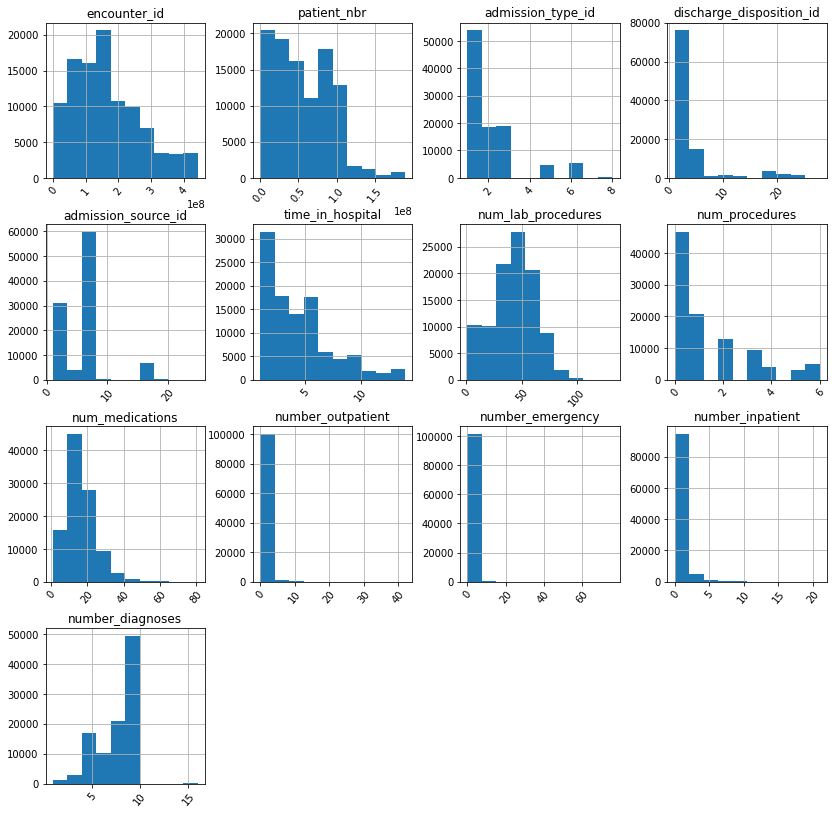

In [4]:
df.hist(figsize=(14,14), xrot=50)

## Panda's Profile

We used the code below to generate a Pandas profile, which allows use to do EDA quickly on the data set. It allows us to visualize and and understand the disbribution of each variable pretty easily. The HTML file will be included as part of the submission.

In [5]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Diabetes Profiling Report", minimal=True)
# profile.to_file(output_file="DiabetesProfile.html")

## Final Feature Set

After evaluating the data above we decided to perform the following data preprocessing steps.



1- Remove Encounter ID, Patient NUBR (unique ids, not needed)

2- Race -> It is a categorical variable, therefore we will impute the missing valuees with the Mode.

3- Age -> Bin in 3 categories, young, middle and old

4- Weight -> Remove, too many unknowns, there is more than 85% of the data that is unknown.

5- Admission ID Type -> Merging values 5, 8 into 6 (see mapping spreadsheet). To put all the missing values in one place.

6- Admission Source -> Merging values 9, 15, 20, 21 into 17. To put all the missing values in one place.

7- Discharge disposition -> remove observations where the discharge disposition is related to hospice or death since these will not add to the possibility of being readmitted 

8- DX -> Bing by using the ICD code in order to have the diagnosis of cardiovascular, respiratory, GI, Endocrinology, Diabetes, Neoplasis, Injury, Uninary and others

9- Remove Payor Code - not helpful, nearly 40% of the data is missing

10- Remove Medical speciality - not helpful, 49% of the data is missing

11- For the Categorical variables we will keep the none buckets, except examide and citoglipton since they only have one value

12- Numerical features, some are normally distrbuted. We will use RobustScaler. The data that look non normaly distributed are the discrete numerical data, therefore we decide no to log transform the data,


13- Readmitted -> Convert to binary as you will see in the code below.

## Drop Unnecessary Columns

First delate the columns that are id of the patients or encounter, so they are usefull for the model, and the columns of weight which is important but the amount of missing values is too much to make it an useful variable, there is 97% of missing values. We also delete the examide medication and citoglipton medication because there is only the no variable, there is not any yes value

In [6]:
l=df["weight"].value_counts(normalize=True)*100
l

?            96.858479
[75-100)      1.312816
[50-75)       0.881434
[100-125)     0.614154
[125-150)     0.142484
[25-50)       0.095317
[0-25)        0.047167
[150-175)     0.034393
[175-200)     0.010809
>200          0.002948
Name: weight, dtype: float64

In [7]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [8]:
df_reduced= df.drop(columns=['encounter_id','patient_nbr','weight','payer_code', 'medical_specialty', 'examide','citoglipton'])
df_reduced.shape
df_reduced.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Categorize Diagnosis Codes into clinical groups

We decided to categorize the diagnosis codes into clinical groups, according to the following paper.

https://www.hindawi.com/journals/bmri/2014/781670/tab2/

In [9]:
# Function to Categorize DX based on URL ...
def bin_dx(code):
    try:
        code = float(code)
    except:
        code = 0

    # Circulatory
    if code in range(390,460) or code == 785:
        return("Circulatory")

    # Respiratory
    elif code in range(460,520) or code == 786:
        return("Respiratory")

    # Digestive
    elif code in range(520,580) or code == 787:
        return("Digestive")

    # Diabetes
    elif code >= 250 and code < 251:
        return("Diabetes")

    # Injury
    elif code in range(800,1000):
        return("Injury")

    # Musculoskeletal
    elif code in range(710,740):
        return("Musculoskeletal")

    # Genitourinary
    elif code in range(580,630) or code == 788:
        return("Genitourinary")

    # Neoplasms
    elif code in range(140,240):
        return("Neoplasms")
    elif code in range(780,783) or code == 784:
        return("Neoplasms")
    elif code in range(790,800):
        return("Neoplasms")
    elif code in range(240,250):
        return("Neoplasms")
    elif code in range(251,280):
        return("Neoplasms")
    elif code in range(680,710):
        return("Neoplasms")
    elif code in range(1,140):
        return("Neoplasms")
    elif code in range(290,320):
        return("Neoplasms")

    # Other
    else:
        return("Other")

In [10]:
df_reduced["Diag1"] = df_reduced["diag_1"].apply(bin_dx)
df_reduced["Diag2"] = df_reduced["diag_2"].apply(bin_dx)
df_reduced["Diag3"] = df_reduced["diag_3"].apply(bin_dx)


print(df_reduced["Diag1"].value_counts())
print("")
print(df_reduced["Diag2"].value_counts())
print("")
print(df_reduced["Diag3"].value_counts())

Circulatory        30437
Neoplasms          16318
Respiratory        14423
Digestive           9475
Diabetes            8757
Injury              6974
Other               5308
Genitourinary       5117
Musculoskeletal     4957
Name: Diag1, dtype: int64

Circulatory        31881
Neoplasms          21462
Diabetes           12794
Respiratory        10895
Genitourinary       8376
Other               7996
Digestive           4170
Injury              2428
Musculoskeletal     1764
Name: Diag2, dtype: int64

Circulatory        30306
Neoplasms          20985
Diabetes           17157
Other              11489
Respiratory         7358
Genitourinary       6680
Digestive           3930
Injury              1946
Musculoskeletal     1915
Name: Diag3, dtype: int64


In [11]:
df_reduced = df_reduced.drop(columns=['diag_1', 'diag_2', 'diag_3'])

## Categorize Age Attribute

In [12]:
print(df_reduced["age"].value_counts())
di = {'[70-80)': 'Old', '[60-70)': 'Old', '[80-90)': 'Old', '[90-100)': 'Old', '[50-60)': 'Midage', '[40-50)': 'Midage', '[30-40)': 'Young', '[20-30)': 'Young', '[10-20)': 'Young', '[0-10)': 'Young'}

df_reduced["age"].replace(di, inplace=True)
print(df_reduced["age"].value_counts())
 

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
Old       68541
Midage    26941
Young      6284
Name: age, dtype: int64


## Group features together for Admission Type and Admission Source

Some of the features or categories can be grouped together. For Admission Type we will place the following three values into the same group, since they sort of represent the same thing.

* 5 - Not Available
* 6 - Null
* 8 - Not Mapped

For Admission Source we will place the following five values into the same group:

* 9 - Not Available
* 15 - Not Available
* 17 - NULL
* 20 - Not Mapped
* 21 - Unknown/Invalid



In [13]:
# reagenge the id coluns can be useful in a way that all the missing values is place in one place and make it categorical
# admission_type_id
df_reduced.admission_type_id.replace(to_replace = 5, value = 6, inplace = True)
df_reduced.admission_type_id.replace(to_replace = 8, value = 6, inplace = True)
df_reduced.admission_type_id = df_reduced.admission_type_id.astype(str)

# admission_source_id
df_reduced.admission_source_id.replace(to_replace = 9, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 15, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 20, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 21, value = 17, inplace = True)
df_reduced.admission_source_id= df_reduced.admission_source_id.astype(str)

## Next, we remove observations where the discharge disposition is related to hospice or death since these will not add to the possibility of being readmitted.

In [14]:
indexNames = df_reduced[df_reduced['discharge_disposition_id'].isin([11,13,14,19,20,21])].index
df_reduced.drop(indexNames, inplace=True)

print(df_reduced['discharge_disposition_id'].value_counts())

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
5      1184
25      989
4       815
7       623
23      412
28      139
8       108
15       63
24       48
9        21
17       14
16       11
10        6
27        5
12        3
Name: discharge_disposition_id, dtype: int64


## Make our response variable a binary variable

The response has 3 values, but we will convert it to binary, if the patient is readmitted within 30 days, the value will be 1, otherwise it will be 0.

In [15]:
di = {'NO': 0, '>30': 0, '<30': 1}

df_reduced["readmitted"].replace(di, inplace=True)
print(df_reduced["readmitted"].value_counts())

0    88029
1    11314
Name: readmitted, dtype: int64


## Plot the readmission variable to show a big inbalance in the response

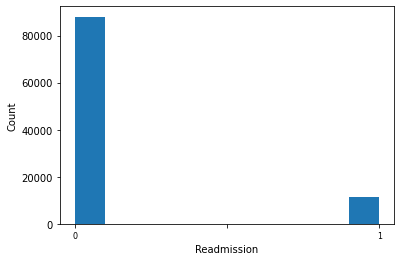

In [16]:
plt.hist(df_reduced["readmitted"])
my_xtick = [0, 0.5, 1]
my_xtick_labels = ['0' , '', '1']
plt.xticks(my_xtick, my_xtick_labels, fontsize=8)
plt.xlabel("Readmission")
plt.ylabel("Count")
plt.show()

# Model Preparation

We decided to use a grid search method to figure the best hyperparameter to choose and to select with lasso the most important variables or to suppress the less important variables with the ridge regularization method. We would use the regularization inside the grid. The models will be evaluated and selected according to the best performance base on the AUC metric. Also, we will scale the numeric variables with robust scaler, and one hot encode the categorical variables; furthermore, we will impute with mean the numerical variables, and impute with mode the categorical variables.
We will choose the AUC metric. The reason why we will use the AUC metric to select the model is because ROC curves are widely used to compare and evaluate different classification algorithms, and ROC curve is widely used when the dataset is imbalanced.

 A Receiver Operating Characteristic curve or ROC curve is created by plotting the True Positive (TP) against the False Positive (FP) at various threshold settings. The ROC curve is generated by plotting the cumulative distribution function of the True Positive in the y-axis versus the cumulative distribution function of the False Positive on the x-axis. The area under the ROC curve (ROC AUC) is the single-valued metric used for evaluating the performance. The higher the AUC, the better the performance of the model at distinguishing between the classes. In general, an AUC of 0.5 suggests no discrimination, a value between 0.5–0.7 is acceptable and anything above 0.7 is good-to-go-model. However, medical diagnosis models, usually AUC of 0.95 or more is considered to be good-to-go-model.

We did not use accuracy to evaluate the model because the data is very imbalance. 

We will use the precision and recall together with confusion matrix to evaluate the selected model. But in order to select the model we will use only the AUC. Precision is the fraction of the correctly classified instances from the total classified instances. Recall is the fraction of the correctly classified instances from the total true positive instances. The confusion matrix provides detailed results of the classification.


# Modeling  & Building Evaluation

One Hot Encode Categorical Variables
Scale numeric features using RobustScaler, why
These features will be treated as categorical
'admission_type_id', 'discharge_disposition_id','admission_source_id'
Why are we are trying SmOTE

Going to use AuC to decide between L1 and L2 with grid search


>>>> Modeling Building and INterpretability
Show the effect that has sampling on threshold
Bo's stuff on recall and how that impacts the threshold
Feature importance
Desribe on final model

Going to use AUC

## Bulding the model with the pipeline using one hot encoder inside the pipeline

In [17]:
categorical_features = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide','chlorpropamide',
                        'glimepiride', 'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
                        'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed',
                        'Diag1', 'Diag2','Diag3', 'age', 'admission_type_id', 'discharge_disposition_id','admission_source_id']

numeric_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 
                    'number_emergency', 'number_inpatient', 'number_diagnoses']

X = df_reduced[categorical_features + numeric_features]
y = df_reduced['readmitted']

# Verify shapes
print(df_reduced.shape)
print(X.shape)
print(y.shape)

(99343, 43)
(99343, 42)
(99343,)


In [18]:

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['scaler', RobustScaler(with_centering=False)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000, n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = [{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__penalty': ['l1'],
               'classifier__solver': ['saga']},
              {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__penalty': ['l2'],
               'classifier__solver': ['lbfgs']}
             ]
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Cross-validation score: 0.644234534279225
Test score: 0.6499155246205435


In [19]:
results_LR = pd.DataFrame(grid_search.cv_results_['params'])
results_LR['test_score'] = grid_search.cv_results_['mean_test_score']
results_LR 

,classifier__C,classifier__penalty,classifier__solver,test_score
0,0.001,l1,saga,0.638362
1,0.010,l1,saga,0.644235
2,0.100,l1,saga,0.639711
3,1.000,l1,saga,0.637912
4,10.000,l1,saga,0.637560
5,100.000,l1,saga,0.637525
6,1000.000,l1,saga,0.637522
7,0.001,l2,lbfgs,0.641122
8,0.010,l2,lbfgs,0.639799
9,0.100,l2,lbfgs,0.638347


## Print the grid best estimator

Explain that L1 and L2 seem to perform the same. Take a look at the important features

In [20]:
print(grid_search.best_params_)

{'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


## Below we find the important features

Summarize the important features

In [21]:
import eli5

onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(grid_search.best_estimator_.named_steps['classifier'], top=50, feature_names=numeric_features_list)

Weight?,Feature
+1.039,discharge_disposition_id_22
+0.343,A1Cresult_None
+0.285,discharge_disposition_id_5
+0.277,number_inpatient
+0.197,race_AfricanAmerican
+0.172,admission_source_id_1
+0.171,admission_source_id_7
+0.166,Diag2_Circulatory
+0.159,Diag1_Circulatory
+0.143,number_diagnoses


# Model Interpretability & Explainability

## Plot confusion matrix

Confusion matrix, without normalization
[[11965  5641]
 [ 1052  1211]]
Normalized confusion matrix
[[0.68 0.32]
 [0.46 0.54]]


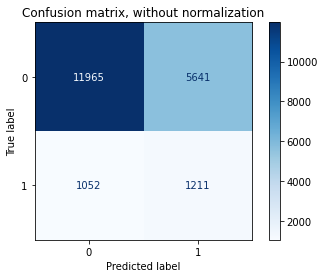

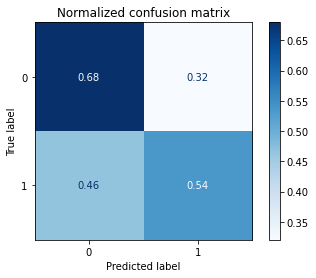

In [22]:

class_names = [0,1]

classifier = grid_search

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Plot ROC

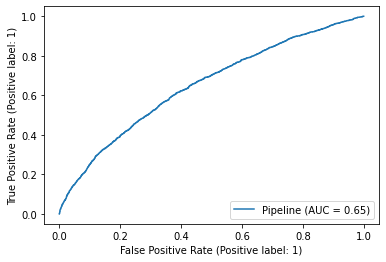

In [23]:
mt.plot_roc_curve(grid_search.best_estimator_, X_test, y_test)

In [24]:
probs_y = grid_search.predict_proba(X_test)
print(probs_y)

probs_y[:,1]

[[0.65 0.35]
 [0.28 0.72]
 [0.68 0.32]
 ...
 [0.74 0.26]
 [0.63 0.37]
 [0.62 0.38]]


array([0.35, 0.72, 0.32, ..., 0.26, 0.37, 0.38])

(0.0, 1.0)

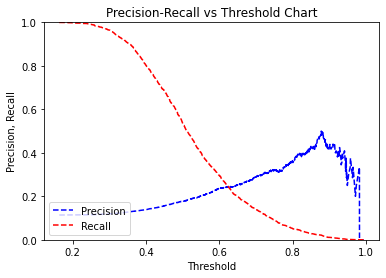

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### `Real World Application example `

- Ideally, we would like to decrease false negatives at the expense of increasing false positives. In case of false negatives, let’s say we have a patient that is predicted to be not readmitted within 30 days, but the patient actually has to come back within 30 days, the patient now risk of missing important treatments within reasonable time window. Whereas in case of false positives, those patients predicted to be readmitted within 30days but actually don’t have, was not done any harm to their body. This means we would like to have a very high recall and wiling to compromise on precision. 

- Adjusting the threshold to find the optimal false negatives and false positives depending on the business needs and resources is crucial. So the question comes...

##### What if we had a business goal to ensure 95% of patients who are readmitted within 30 days are classifed as patients who are to be readmitted within 30 days? 

This means we want to have 95% recall. Now let's see what that means in terms of changes in threshold and precision. 
So both the threshold and the precision turns out to be relatively low when the recall is 0.95. 

In [26]:
readmit95_ind = np.argmin(recall >= 0.95)-1
readmit95_thresh = thresholds[readmit95_ind]
readmit95_precision = precision[readmit95_ind]
readmit95_recall = recall[readmit95_ind]

print("Threshold:", readmit95_thresh)
print("Precision:", readmit95_precision)
print("Recall:", readmit95_recall)

Threshold: 0.31311875774196135
Precision: 0.12091558405039086
Recall: 0.9500662836942112


Now we will tie these findings to the question of: 
##### How much resources (time and money) can the pathology department save utilizing this information? 

- We want to find out how much sampling is required to ensure certain precision and recall for this question. 
- The key is to keep the threshold low to not miss any patients who have to be readmitted within 30days. In this case above, we have about 88%(1-precision) of patients we predict to be readmitted within 30 days actually get readmitted within 30 days. 

##### With this threshold, how much fraction of the sample did the model identify as not having to be readmitted within 30 days?
- From the result below, there is roughly 65% of the data that are below the threshold and that means those 65% of the data doesn't need to be processed to be able to reach the business goal of ensuring 95% of patients who are admitted within 30 days are classified as patients who are to be readmitted within 30 days. 

__`So sparing 65% of the sampling work at the pathology department could save a lot of resources depending on the scale of the data. However, this means 5% of the patients who are diagnosed to not having to come back to the hospital within 30 days actually have to be readmitted within 30 days. This could be unacceptable in certain situations and patient's conditions. Thus here below we will keep improving the model by tuning the threshold. `__

In [27]:
print("Proportion of samples below threshold:", np.mean(grid_search.best_estimator_.predict(X) < readmit95_thresh))

Proportion of samples below threshold: 0.6474034406047734


# Tunning the threshold for classification


******** For i = 0.01 ******
0.11389601892395189
Precision= 0.11389601892395189
Recal= 0.11389601892395189
fscore= 0.023291766747235054
Confusion Matrix = [[    0 17606]
 [    0  2263]]


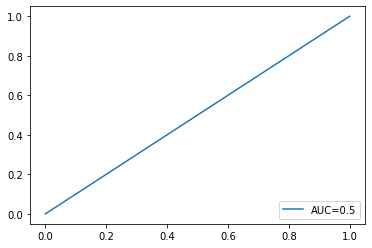


******** For i = 0.1 ******
0.11389601892395189
Precision= 0.11389601892395189
Recal= 0.11389601892395189
fscore= 0.023291766747235054
Confusion Matrix = [[    0 17606]
 [    0  2263]]


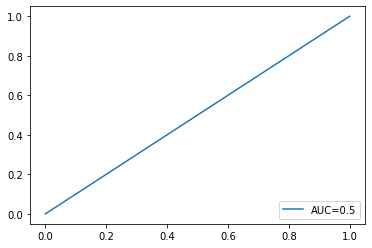


******** For i = 0.2 ******
0.11807338064321304
Precision= 0.11807338064321304
Recal= 0.11807338064321304
fscore= 0.032149849120595674
Confusion Matrix = [[   88 17518]
 [    5  2258]]


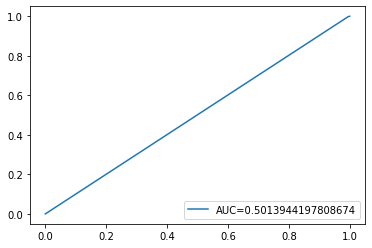


******** For i = 0.25 ******
0.13614172832049928
Precision= 0.13614172832049928
Recal= 0.13614172832049928
fscore= 0.06894987955033821
Confusion Matrix = [[  463 17143]
 [   21  2242]]


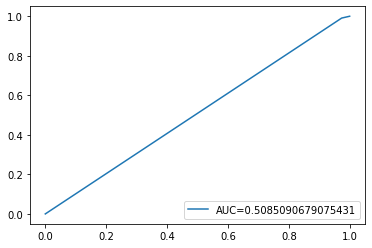


******** For i = 0.3 ******
0.18747798077407016
Precision= 0.18747798077407016
Recal= 0.18747798077407016
fscore= 0.1664370701983239
Confusion Matrix = [[ 1543 16063]
 [   81  2182]]


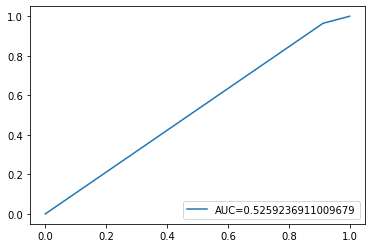

In [28]:
pred_proba_df = pd.DataFrame(grid_search.predict_proba(X_test))
threshold_list = [0.01, 0.1,0.2, 0.25, 0.3]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    accuracy = mt.accuracy_score(y_test, Y_test_pred.iloc[:,1])
    print(accuracy)
    precision = mt.precision_score(y_test, Y_test_pred.iloc[:,1], average='micro')
    print("Precision=", precision)
    recal = mt.recall_score(y_test, Y_test_pred.iloc[:,1], average='micro')
    print("Recal=", recal)
    fscore = mt.f1_score(y_test, Y_test_pred.iloc[:,1], average='weighted')
    print("fscore=",fscore )
    # Confusion matrix
    cm= confusion_matrix(y_test, Y_test_pred.iloc[:,1])
    print("Confusion Matrix =", cm)
    fpr, tpr, _ = roc_curve(y_test, Y_test_pred.iloc[:,1])
    auc = roc_auc_score(y_test, Y_test_pred.iloc[:,1])
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.show()
    

# Conclusion